# C-mean Clustering
Fuzzy c-Means Clustering} (FMC) is a clustering method which, unlike Hard k-Means Clustering, allows a data sample to more or less belong to one or more clusters. In this notebook, we will try to develop a semi-supervised C-mean Clustering.

## Loading the packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import random
import operator
import math
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

PATH_TO_DATASET = '' # Not Given Yet 

%matplotlib inline

## The dataset
The following script allows you to create a 2D dataset by using the mouse. The fift first click adds points belonging to class A (blue), the 5th following click adds points belonging to class B (red) and the next click add unclassified points. You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {0,1,2} where 0 represent unclassified points.

<IPython.core.display.Javascript object>


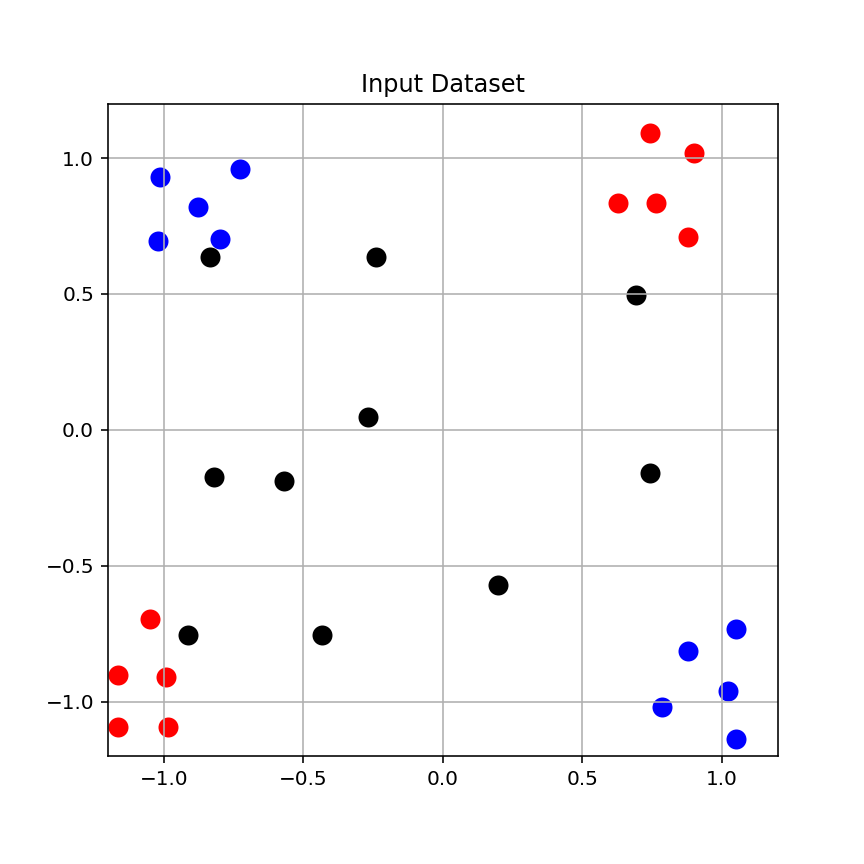

In [7]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
plt.title("Input Dataset")
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))

dataset = []

i = 0
def onclick(event):
    global dataset
    global i
    cx = event.xdata
    cy = event.ydata
    classe = 1 if(i<10) else 2 if(i<20) else 0
    i=i+1
    dataset.append((cx, cy, classe))

    plt.scatter(cx, cy, c=['k', 'b', 'r'][classe], s=100, lw=0)
    plt.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [8]:
dataset = np.array(dataset)

## Membership Matrix
The Membership matrix lists all the data samples membership grades to a particular cluster. Here we first randomly initialize it.

In [9]:
def initializeMembershipMatrix(dataset, k):
    membership_mat = list()
    for i in range(len(dataset)):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

## Cluster Center
Here we calculate each cluster center depending on the membership grades.

In [10]:
def calculateClusterCenter(dataset, membership_mat, k, fuzzy_param):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = list()
    for j in range(k):
        x = cluster_mem_val[j]
        xraised = [e ** fuzzy_param for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(len(dataset)):
            data_point = dataset[i]
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

## Semi-supervised C-Mean

In [11]:
def evalConvergence(mb, previous_mb, threshold):
    return (np.absolute(np.array(mb) - np.array(previous_mb))).max() < threshold
        

In [24]:
def initializeMembershipMatrixSupervised(dataset, k):
    membership_mat_supervised = list()
    for i in range(len(dataset)):
        if (dataset[i][2] == 0):
            random_num_list = [0 for i in range(k)]
        else:
            random_num_list = [1 if((i+1)==dataset[i][2]) else 0 for i in range(k)]
        
        membership_mat_supervised.append(random_num_list)
    return membership_mat_supervised

In [13]:
def evalAccuracy(dataset, k):
    pass

In [43]:
def calculateClusterCenterSup(dataset, membership_mat, membership_mat_sup,  k, fuzzy_param):
    cluster_centers = []
    for i in range(k):
        for n in range(len(dataset)):
            denum = abs(membership_mat[n][i] - membership_mat_sup[n][i]) ** fuzzy_param
            num = denum*dataset[n]#dataset[n, :-1] ? 
        cluster_centers.append(num/denum)
    return cluster_centers

In [50]:
def updateMembershipValueSup(dataset, membership_mat, membership_mat_sup, cluster_centers, fuzzy_param, k):
    def d(n, c):
        return np.linalg.norm(list(map(operator.sub, dataset[n], cluster_centers[c])))** 2
    p = 1/(fuzzy_param- 1)
    
    for i in range(k):
        for n in range(len(dataset)):  
            membership_mat[n][i] = membership_mat_sup[n][i] + (1 - np.sum(membership_mat_sup[n])) * d(n, i) ** p / np.sum([d(n,j) for j in range(k)])
    return membership_mat

## Main Execution 
blablabla

In [52]:
def updateMembershipValue(dataset, membership_mat, cluster_centers, fuzzy_param, k):
    p = float(2/(fuzzy_param-1))
    for i in range(len(dataset)):
        x = dataset[i]
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat


def getClusters(dataset, membership_mat):
    cluster_labels = list()
    for i in range(len(dataset)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels


def fuzzyCMeansClustering(dataset, k = 2, threshold = 0.1, fuzzy_param = 2.00, maxSteps = 10000):
    # Membership Matrix
    membership_mat = initializeMembershipMatrix(dataset, k)
    membership_mat_sup = initializeMembershipMatrixSupervised(dataset, k)
    previous_mb = np.zeros((len(dataset), k))
    steps = 0
    
    while not evalConvergence(membership_mat, previous_mb, threshold) or steps >= maxSteps:
        print(membership_mat)
        cluster_centers = calculateClusterCenterSup(dataset[:,:-1], membership_mat, membership_mat_sup, k, fuzzy_param)
        print(membership_mat)
        membership_mat = updateMembershipValueSup(dataset[:,:-1], membership_mat, membership_mat_sup, cluster_centers, fuzzy_param, k)
        print(membership_mat)
        cluster_labels = getClusters(dataset[:,:-1], membership_mat)
        previous_mb = membership_mat
        steps += 1
    return cluster_labels, cluster_centers, membership_mat

labels, centers, mb = fuzzyCMeansClustering(dataset)

centers = np.array(centers)
# Visualize the test data
fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")

plt.scatter(dataset[:,0], dataset[:,1], c=[(['r', 'b', 'orange', 'brown'])[int(label)] for label in labels])
plt.scatter(centers[:,0], centers[:,1], c='y')
plt.grid()
plt.show()

[[0.4660337035876216, 0.5339662964123784], [0.551690082024486, 0.448309917975514], [0.7750697598972657, 0.22493024010273435], [0.3804810250869006, 0.6195189749130994], [0.1184406567097434, 0.8815593432902566], [0.31853595455421463, 0.6814640454457854], [0.504959404136552, 0.4950405958634479], [0.6558015049098539, 0.3441984950901461], [0.8155873168640658, 0.18441268313593415], [0.44126865611908433, 0.5587313438809156], [0.17703921828486024, 0.8229607817151398], [0.5464927633383819, 0.45350723666161813], [0.3565715899443426, 0.6434284100556573], [0.6076261201846245, 0.3923738798153755], [0.37423131008573424, 0.6257686899142657], [0.456895480619146, 0.5431045193808541], [0.5738497904384263, 0.42615020956157373], [0.34937870069533267, 0.6506212993046674], [0.3402265065019004, 0.6597734934980996], [0.3845183403882273, 0.6154816596117726], [0.5710030749478122, 0.4289969250521878], [0.4436650092534918, 0.5563349907465082], [0.7512615061280328, 0.2487384938719672], [0.7439874018246778, 0.25601

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)



[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], 

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan]]
[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [

KeyboardInterrupt: 

## Results and Analyse

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    labels_names = ["Woman", "Man"]
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

In [ ]:
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)